In [1]:
import sys
import importlib
sys.path.insert(0, './hxetda/')
import hxetda
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support
from sklearn.utils import class_weight

In [2]:
# Let's import preprocess our variable star data
scaler = StandardScaler()
vertices = np.asarray(['Object','**', 'AGB*', 'AGN',  'Ae*', 
			'BLLac', 'BYDra', 'Be*', 'BlueStraggler','C*',  
			'Cepheid','EB*', 'EllipVar', 'Em*', 'Eruptive*', 
	'HB*', 'HotSubdwarf', 'Irregular_V*', 'LPV*', 'Mira', 
'OH/IR', 'Orion_V*', 'Pec*','PulsV*', 'PulsV*RVTau', 
'PulsV*WVir','PulsV*delSct', 'QSO', 'RGB*', 'RRLyr',
 'RSCVn', 'RedSG*', 'RotV*', 'S*', 'SB*', 
 'Seyfert','Star', 'TTau*','V*', 'WD*', 
 'YSO', 'deltaCep', 'gammaDor', 'low-mass*', 'SG*','EV*','MS','Ma*', 'Blazar','CV'],dtype=str)

# I am adding some conversions here for events which are either "candidates" or have <5 objects
conversions = {'AGN_Candidate':'AGN', 'Blazar_Candidate':'Blazar',
				'Candidate_AGB*':'AGB*', 'Candidate_Ae*':'Ae*',
				'Candidate_C*':'C*', 'Candidate_CV*':'CV',
				'Candidate_EB':'EB*', 'Candidate_HB*':'HB*',
				'Candidate_LP*':'LPV*', 'Candidate_Mi*':'Mira',
				'Candidate_RGB*':'RGB*','Candidate_RRLyr':'RRLyr',
				'Candidate_S*':'S*','Candidate_TTau*':'TTau*',
				'Candidate_WD*':'WD*','Candidate_YSO':'YSO',
				'CataclyV*':'CV','PN?':'EV*','QSO_Candidate':'QSO',
				'V*?':'V*','Seyfert_1':'Seyfert','Seyfert_2':'Seyfert',
				'Erupt*RCrB':'Eruptive*','HMXB':'**','LINER':'AGN',
				'Nova':'CV','PulsV*bCep':'PulsV*','RotV*alf2CVn':'RotV*',
				'Symbiotic*':'**','WR*':'SG*','YellowSG*':'SG*',
				'post-AGB*':'EV*', 'pulsV*SX':'PulsV*',
				'PN':'EV*'}

def make_dataset(load=False):
    # to do - eventually, I do want to save/load a dataset...
	if not load:
		N = 46078
		N = 30000
		all_labels = np.asarray(['strifffffdddddddfng']*N, dtype=str)
		all_dat = np.zeros((N,19))
		data = pd.read_csv('./data/SIMBAD_ZTF_crossmatch.csv')
		data2 = np.loadtxt('./data/Table2.txt',skiprows=34, usecols=(1,4,5,6,8,9,10,11,14,15,16,17,18,19,20,21,22,23,25,26))
		counter = 0
		for i,my_id in enumerate(data['ZTF_ID']):
			if i%1000==0:
				print(i)
			if counter>N-1:
				break
			gind = np.where(data2[:,0]==my_id)
			if data['SIMBAD_OTYPE'][i] in vertices:
				all_labels[counter] = data['SIMBAD_OTYPE'].values[i]
			else:
				try:
					all_labels[counter] = conversions[data['SIMBAD_OTYPE'].values[i]]
				except:
					continue
			all_dat[counter] = data2[gind[0],1:]

			counter+=1

		return(all_labels,all_dat)

labels,all_features = make_dataset()
scaler.fit(all_features)
all_features = scaler.transform(all_features)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


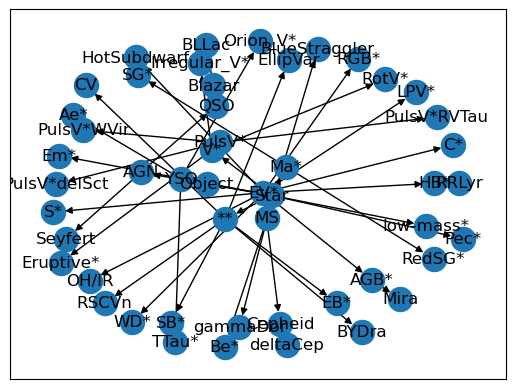

In [3]:
# Make a graph

G=nx.DiGraph()
G.add_edge('Object','Star')
G.add_edge('Object','AGN')

# AGN
G.add_edge('AGN','QSO')
G.add_edge('Blazar','BLLac')
G.add_edge('AGN','Seyfert')
G.add_edge('QSO','Blazar')

#rando stars
G.add_edge('Star','Em*')
G.add_edge('Star','Pec*')
G.add_edge('Star','low-mass*')

#Massive stars
G.add_edge('Star','Ma*')
G.add_edge('Ma*','SG*') 
G.add_edge('Ma*','RedSG*')

#Young stars
G.add_edge('Star','YSO') 
G.add_edge('YSO','Ae*')
G.add_edge('YSO','Orion_V*')
G.add_edge('YSO','TTau*')

#Main sequence
G.add_edge('Star','MS') 
G.add_edge('MS','Be*') 
G.add_edge('MS','BlueStraggler')
G.add_edge('MS','gammaDor')

#evolved stars
G.add_edge('Star','EV*')
G.add_edge('EV*','AGB*')
G.add_edge('AGB*','Mira')
G.add_edge('EV*','C*')
G.add_edge('EV*','Cepheid')
G.add_edge('EV*','HB*')
G.add_edge('EV*','HotSubdwarf')
G.add_edge('EV*','LPV*')
G.add_edge('EV*','OH/IR')
G.add_edge('EV*','RGB*')
G.add_edge('HB*','RRLyr')
G.add_edge('EV*','S*')
G.add_edge('EV*','WD*')
G.add_edge('Cepheid','deltaCep')

#binary...
G.add_edge('Star','**')
G.add_edge('**','BYDra')
G.add_edge('**','EB*')
G.add_edge('**','EllipVar')
G.add_edge('**','RSCVn')
G.add_edge('**','SB*')
G.add_edge('**','CV')


#variable - other
G.add_edge('Star','V*')
G.add_edge('V*','Eruptive*')
G.add_edge('V*','Irregular_V*')
G.add_edge('V*','PulsV*')
G.add_edge('PulsV*','PulsV*RVTau')
G.add_edge('PulsV*','PulsV*WVir')
G.add_edge('PulsV*','PulsV*delSct')
G.add_edge('V*','RotV*')

nx.draw_networkx(G, nodelist=vertices)
plt.show()
#to do -- beautify

In [4]:
# Some pre-processing for the graph
paths, pathlengths, mask_list, y_dict = hxetda.calc_path_and_mask(G, vertices, 'Object')

In [41]:
# Some pre-processing for the class weights
importlib.reload(hxetda)

class_weight_dict = hxetda.calc_class_weights(labels, vertices, paths)

In [6]:
# Set up for train test split...
labels_new = [y_dict[x] for x in labels]
weights = [class_weight_dict[x] for x in labels]
X_train, X_test, y_train, y_test, labels_train, labels_test, weights_train, weights_test = train_test_split(all_features, labels_new, labels, weights,test_size=0.33, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

weights_train = torch.tensor(weights_train, dtype=torch.float32)
weights_test = torch.tensor(weights_test, dtype=torch.float32)



/var/folders/3g/dt9n1tgn3tb2py7t74lkz8y80000gn/T/ipykernel_10586/68655873.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  y_train = torch.tensor(y_train, dtype=torch.float32)


1 -2.2376015 -2.2064898
11 -2.683017 -2.657275
21 -2.792719 -2.756577
31 -2.8365571 -2.7962022
41 -2.8549223 -2.811797
51 -2.8774195 -2.8312688
61 -2.9052455 -2.8433688
71 -2.9151194 -2.85193
81 -2.9311078 -2.8612099
91 -2.9383278 -2.8629513
101 -2.9427013 -2.8642151
111 -2.9380932 -2.86594
121 -2.9541483 -2.8689773
131 -2.9552872 -2.864965
141 -2.9588623 -2.8659444
151 -2.9647026 -2.8660917
161 -2.9666278 -2.8557115
171 -2.9677508 -2.8703873
181 -2.9713078 -2.8633907
191 -2.9713483 -2.8635817
201 -2.9766955 -2.8627393
211 -2.9713223 -2.8623571
221 -2.972666 -2.86651
231 -2.9690852 -2.8639026
241 -2.9780512 -2.8654053
251 -2.9726799 -2.8632643
261 -2.9792404 -2.8659873
271 -2.9802697 -2.8654513
281 -2.9748056 -2.8459377
291 -2.977853 -2.8632324
301 -2.9589627 -2.8484626
311 -2.9843936 -2.8632998
321 -2.986087 -2.8599617
331 -2.9797273 -2.8577673
341 -2.9882715 -2.8567052
351 -2.9913194 -2.8570921
361 -2.9902704 -2.8553586
371 -2.9935904 -2.8522582
381 -2.993421 -2.8511128
391 -2.980050

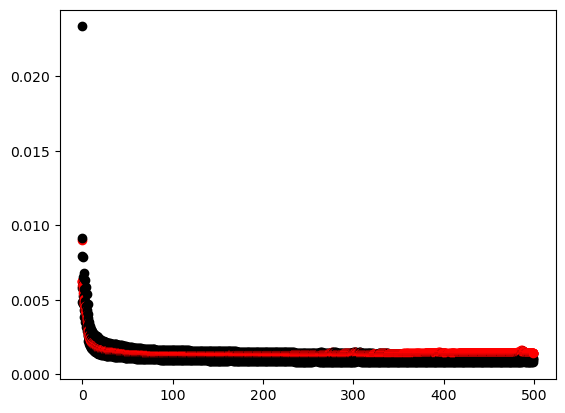

In [42]:
# Train!
model = hxetda.Feedforward(np.shape(X_test[0])[0],20, len(vertices))
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.1)
model.train()
epoch = 500
n_batches = 4096
loss=torch.tensor(0)
for epoch in range(epoch):
	if epoch%10==1:
		print(epoch, np.log10(loss.detach().numpy()), np.log10(loss2.detach().numpy()))
	for i in range(int(len(X_train)/n_batches)+1):
		# Local batches and labels
		local_X, local_y, local_weights = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,], weights_train[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred = model(local_X)
		# Compute Loss
		loss = hxetda.custom_hier_loss(y_pred.to(torch.float),local_y.to(torch.float), local_weights, mask_list, pathlengths)
		# Backward pass
		loss.backward()
		optimizer.step()
		plt.plot(epoch,loss.detach().numpy(),'ko')
		ypred2 = model(X_test)
		loss2 = hxetda.custom_hier_loss(ypred2.to(torch.float),y_test.to(torch.float), weights_test, mask_list, pathlengths)
		plt.plot(epoch,loss2.detach().numpy(),'ro')
	
#scheduler.step()
plt.show()

In [43]:
model.eval()
y_pred = model(X_test)


8333
(0.27077651661925833, 0.24400740281099234, 0.2341359396892947, None)
(0.9115564622584903, 0.9115564622584903, 0.9115564622584903, None)


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


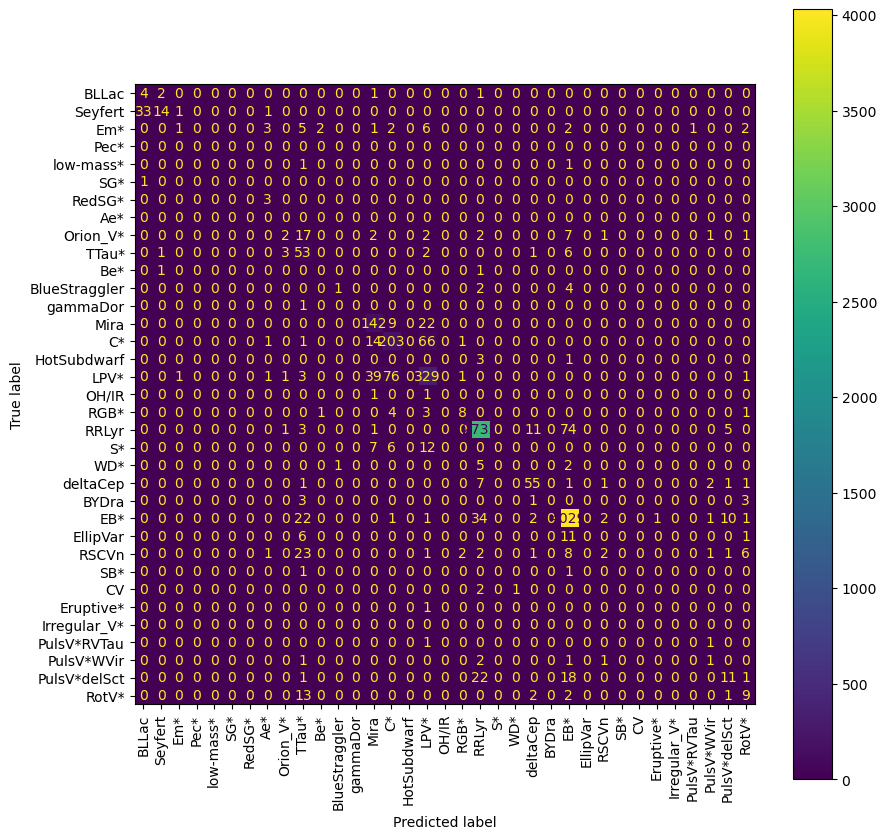

In [44]:

# Get my leaves...
leaves = np.asarray([x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1], dtype=str)

probs_list = np.zeros((len(y_pred), len(leaves)))
for i,leaf in enumerate(leaves):
    probs_list[:,i] = hxetda.get_prob(y_pred,leaf, paths, vertices, mask_list).detach().numpy()

my_predicted_types = leaves[np.argmax(probs_list,axis=1)]

gind = np.where(np.in1d(labels_test,leaves))[0]
cm = confusion_matrix(labels_test[gind], my_predicted_types[gind], labels=leaves)
disp = ConfusionMatrixDisplay(cm, display_labels=leaves)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)
print(len(gind))

print(precision_recall_fscore_support(labels_test[gind], my_predicted_types[gind],average='macro'))
print(precision_recall_fscore_support(labels_test[gind], my_predicted_types[gind],average='micro'))

8333


/var/folders/3g/dt9n1tgn3tb2py7t74lkz8y80000gn/T/ipykernel_10586/2142589040.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  baseline_ytest = torch.tensor(baseline_ytest)


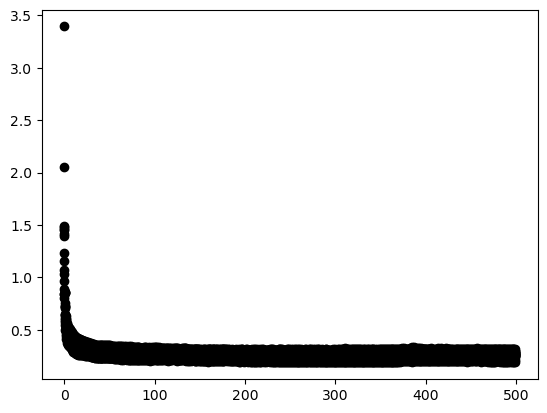

In [35]:
# Now for the same training/test set...train a baseline
# Train!

gind = np.where(np.in1d(labels_test,leaves))[0]
baseline_Xtest = X_test[gind]
baseline_ytest = y_test[gind]
baseline_labels_test = labels_test[gind]

print(len(gind))

gind = np.where(np.in1d(labels_train,leaves))[0]
baseline_Xtrain = X_train[gind]
baseline_ytrain = y_train[gind]
baseline_labels_train = labels_train[gind]

# Now only keep relevant columns...

new_baseline_ytest = np.zeros((len(baseline_ytest), len(leaves)))
new_baseline_ytrain = np.zeros((len(baseline_ytrain), len(leaves)))

for i,leaf in enumerate(leaves):
    j = np.where(leaf == vertices)[0][0]
    new_baseline_ytrain[:,i] = baseline_ytrain[:,j]
    new_baseline_ytest[:,i] = baseline_ytest[:,j]

baseline_ytrain = torch.tensor(new_baseline_ytrain)
baseline_ytest = torch.tensor(baseline_ytest)

model_baseline = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(leaves))
optimizer = torch.optim.AdamW(model_baseline.parameters(), lr = 0.1)
model_baseline.train()
epoch = 500
n_batches = 1024


#class_weights=class_weight.compute_class_weight('balanced',classes=np.unique(labels_test),y=my_predicted_types)

myloss = torch.nn.CrossEntropyLoss()

for epoch in range(epoch):
	for i in range(int(len(baseline_Xtrain)/n_batches)+1):
		# Local batches and labels
		local_X, local_y = baseline_Xtrain[i*n_batches:(i+1)*n_batches,], baseline_ytrain[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred_baseline = model_baseline(local_X)
		# Compute Loss
		loss = myloss(y_pred_baseline,local_y)
		# Backward pass
		loss.backward()
		optimizer.step()
		plt.plot(epoch,loss.detach().numpy(),'ko')
	#scheduler.step()
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.24925677279148445, 0.2429741545408996, 0.23281696291093681, None)
(0.9168366734669386, 0.9168366734669386, 0.9168366734669386, None)


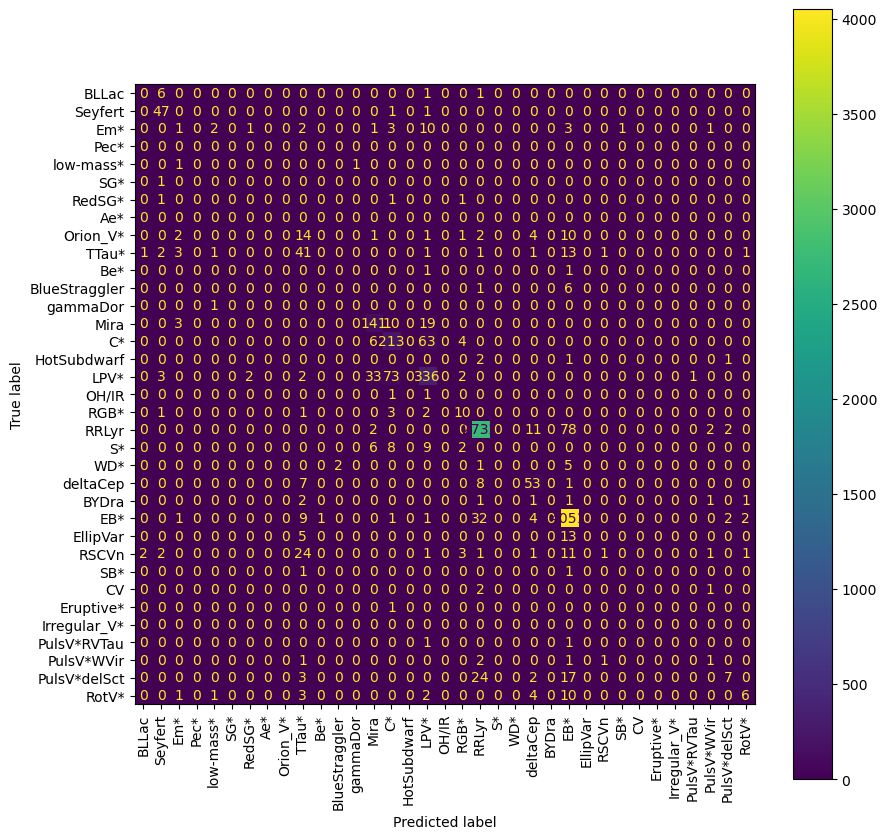

In [45]:
model_baseline.eval()
y_pred_baseline = model_baseline(baseline_Xtest).detach().numpy()
predicted_baseline_types = leaves[np.argmax(y_pred_baseline,axis=1)]
cm = confusion_matrix(baseline_labels_test, predicted_baseline_types, labels=leaves)
disp = ConfusionMatrixDisplay(cm, display_labels=leaves)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)

print(precision_recall_fscore_support(baseline_labels_test, predicted_baseline_types,average='macro'))
print(precision_recall_fscore_support(baseline_labels_test, predicted_baseline_types,average='micro'))